<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [63]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats


## Import dataset BSD

In [24]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))

print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

22224896/22211847 [==============================] - 0s 0us/step
300


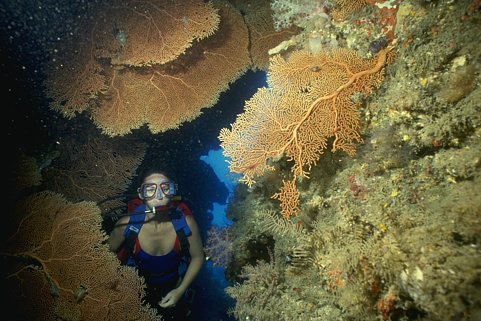

In [25]:
PIL.Image.open(str(test_temp[0]))

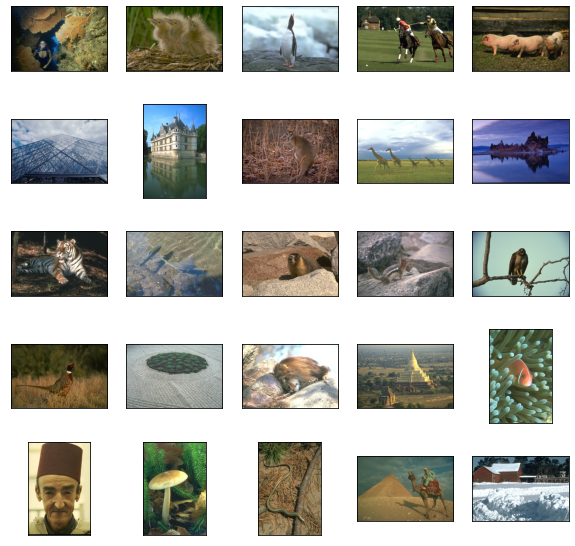

In [26]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per caricare immagini in array di pixel e ruotare

In [27]:
test=[]
for i in range(image_count_test):
  image=PIL.Image.open(str(test_temp[i]))
  if(image.height > image.width):
    image=image.transpose(PIL.Image.ROTATE_90)
  test.append(np.array(image.convert('RGB')))
  
train=[]
for i in range(image_count_train):
  image=PIL.Image.open(str(train_temp[i]))
  if(image.height > image.width):
    image=image.transpose(PIL.Image.ROTATE_90)
  train.append(np.array(image.convert('RGB')))

image_size=[image.width, image.height]
print(image_size)

[481, 321]


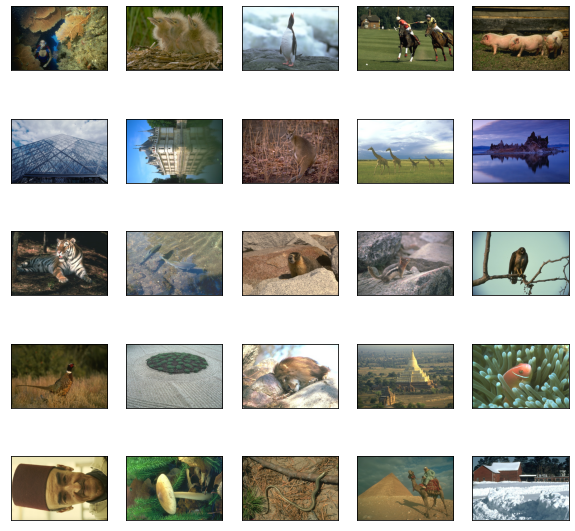

In [28]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
   
plt.show()

## Adding Noise

In [73]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [119]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.4, 0.6
    sigma = 0.04

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return

  return 255*noise_img #random_noise returns [0,1] or [-1,1] value

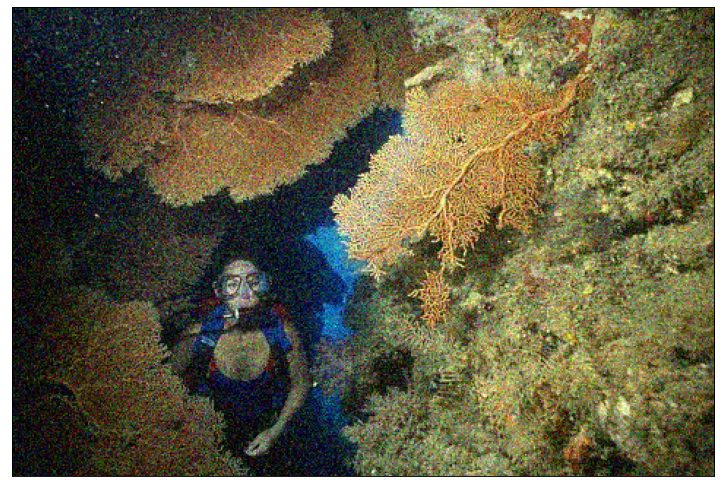

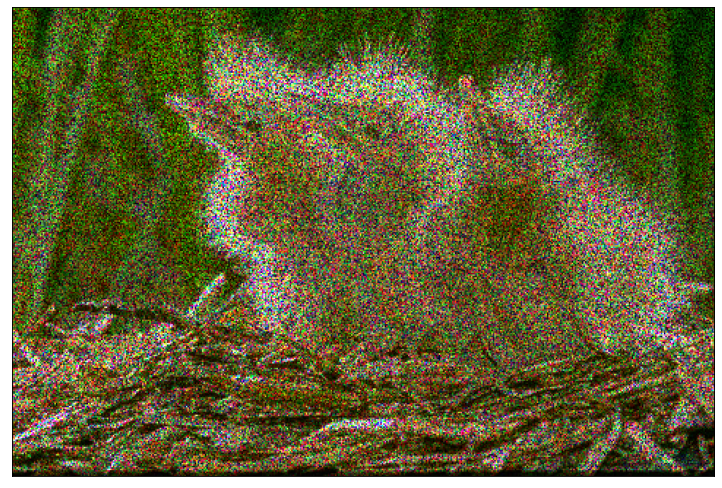

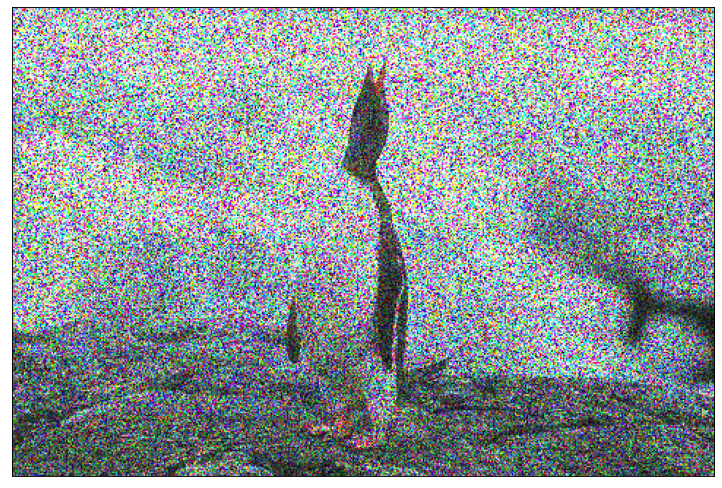

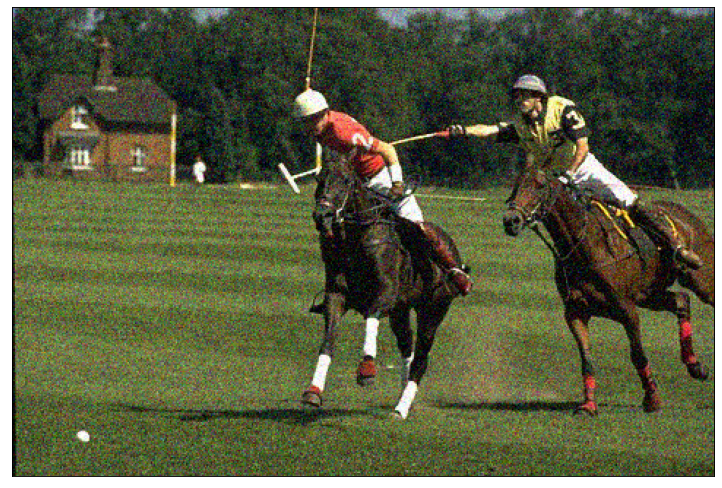

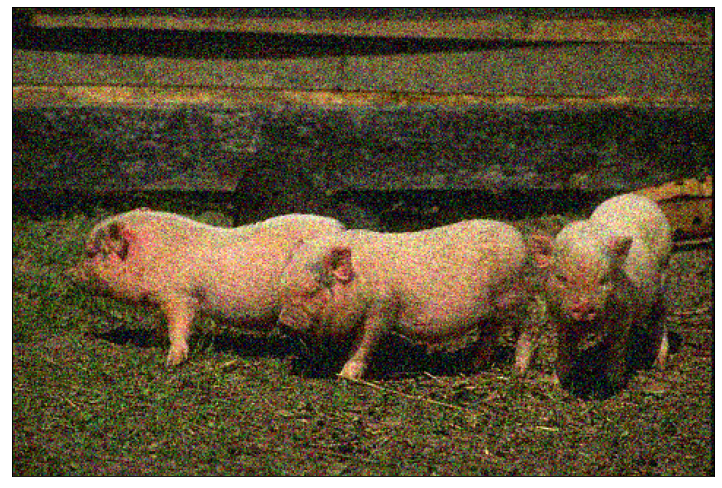

In [120]:
from matplotlib import pyplot as plt

for i in range(5):
    plt.figure(figsize=(50,45), dpi=80)

    img = cv2.imread(str(test_temp[i]))
    noise_img=apply_noise_to_image(img)
    noise_img=np.array(noise_img, dtype = 'uint8')
    noise_img_rgb=cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)

    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((noise_img_rgb), cmap=plt.cm.binary)
   
plt.show()

## Generatore - Discriminatore 

In [ ]:
def build_generator(width, height, inputDim=100, n1=512, channels=3):

  inp = Input(shape=(inputDim,))

  # FC - BN 
  dim1 = width // 16     # because we have 4 transpose conv layers with strides 2 -> 
                        # -> we are upsampling by a factor of 16
  dim2 = height // 16
  
  x = Dense( dim1 * dim2 * n1, activation="relu")(inp)
  x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  # Reshape to width * heigh * feature_channels

  x = Reshape((dim1, dim2,n1))(x)

  # alternative formulation: batchnorm before activation
  #x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  #x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)
  #x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

 
  # now add conv 2D transpose
  x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  
  # now add final layer with tanh activation
  out = Conv2DTranspose(channels, (5,5), strides=(2,2), padding="same", activation="tanh")(x)

  m = Model(inputs=inp, outputs=out)
  return m

In [ ]:
def build_discriminator(width, height, channels, alpha=0.2, droprate=0.4):
    input_shape = (width, height, channels)

    # use Leaky ReLU instead of Relu in the discriminator
    leaky = tf.keras.layers.LeakyReLU(alpha)
    n1 = 128
    n2 = 256
    n3 = 512

    inp = Input(shape=input_shape)
    x = Conv2D(n1, (5,5), strides=(2,2), activation=leaky)(inp)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n2, (5,5), strides=(2,2), activation=leaky)(x)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n3, (3,3), strides=(2,2), activation=leaky)(x)
   # x = MaxPooling2D(strides=2)(x)
   
    x = Flatten()(x)
   # x = Dense(n3/8, activation=leaky)(x)

    #use dropout to increase variability in the discriminator
    x = Dropout(droprate)(x)
    out = Dense(1, activation="sigmoid")(x)

    m = Model(inputs=inp, outputs=out)
    return m